# Objective
Assuming that the daily demand is drawn from a normal distribution, we try identify the sample size required to estimate the optimal solution. This gives us an understanding of the required minimal complexity of the Optimization problem.

### Load main modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pulp

# Set seaborne
sns.set()

### Load data

In [2]:
dfSales = pd.read_csv("avocado_sales.csv")
dfSales["date"] = pd.to_datetime(dfSales["date"])

# Descriptive statistics
dfSales.head(10)

,date,sales,price
0,2021-01-01,1031,1.21
1,2021-01-02,2969,1.18
2,2021-01-03,2419,1.23
3,2021-01-04,2525,1.20
4,2021-01-05,2517,1.19
5,2021-01-06,3283,1.19
6,2021-01-07,1848,1.21
7,2021-01-08,1916,1.19
8,2021-01-09,2188,1.18
9,2021-01-10,1489,1.20


### Optimization model for quantity

<b>Non-parametric formulation</b>

The function <b>find_optimal_quantity</b> solves the non-parametric model for a given demand array

In [3]:
# Find optimal quantity and optimal expected cost for a given sample size
def find_optimal_quantity(demands):
    # Generate demand sample indices
    samples = range(0, len(demands))

    # Initialize model and objective sense
    nonparamModel = pulp.LpProblem(name="NonParametric", sense=pulp.LpMinimize)

    # Our main decision variable: z
    zvar = pulp.LpVariable("z", lowBound=0.0, cat=pulp.LpContinuous)

    # Demand loss and extra supply variables    
    lvar = pulp.LpVariable.dict("l", samples, lowBound=0.0)
    svar = pulp.LpVariable.dict("s", samples, lowBound=0.0)

    # Create constraints
    for s in samples:
        # Demand loss
        nonparamModel += ( lvar[s] >= demands[s] - zvar )
        # Extra supply
        nonparamModel += ( svar[s] >= zvar - demands[s] )

    # Objective function
    r = 1.20
    c = 0.25 
    obj = pulp.lpSum([ r * lvar[s] for s in samples ])
    obj += pulp.lpSum([ c * svar[s] for s in samples ])

    # Add objective to model
    nonparamModel += 1/len(samples) * obj

    # Solve model
    nonparamModel.solve()
    if nonparamModel.status != pulp.constants.LpStatusOptimal:
        print("Error: optimal solution NOT found - please check model!")

    # Expected value:
    expectedCost = pulp.value(nonparamModel.objective)
    #print("Expected value: " + str(expectedCost))

    # Optimal "z"
    z = zvar.value()
    
    # Return list with optimal z and expected cost
    return [z, expectedCost]

### Samples from Normal

As we have seen in class, the sales distribution is close to a Normal. We will create a Normal distribution with the same parameters to obtain multiple samples

In [4]:
# Generate Normal distribution
from scipy import stats
salesdist = stats.norm(dfSales["sales"].mean(), dfSales["sales"].std())

# Create demand samples (~10,000)
demandsamples = salesdist.rvs(size=10000, random_state=0)
demandsamples

array([3084.59145152, 2268.48692723, 2614.68831452, ..., 2338.32485897,
       2009.34909106, 2805.78960127])

### Analysis of the approximation quality vs. sample size

In [5]:
# Calculate optimal for different number of samples (up to 10,000 here)
# It may take a while to run everything!

samplesizes = range(2, 1000, 10)
optz = []
optcost = []
for size in samplesizes:    
    z, cost = find_optimal_quantity(demandsamples[0:size])
    optz.append(z)
    optcost.append(cost)

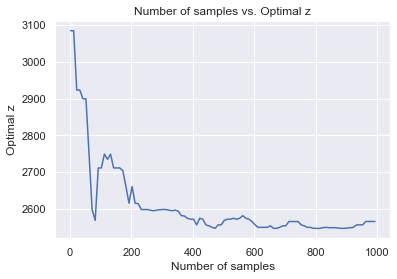

In [6]:
# Plot - optimal solution
plt.plot(samplesizes, optz)
plt.xlabel("Number of samples")
plt.ylabel("Optimal z")
plt.title("Number of samples vs. Optimal z")

plt.show()

In [14]:
min(optz)

2546.0646

As visible in the above plot, the optimal z fluctuates when the sample size is small. It also increases for a while but it starts saturating after number of samples>200. It hovers around 2613 at n = 220 and reaches a min of of 2546. This range is very close to the optimal z of 2594.
Hence, a sample size of 220 would provide a good estimate of the optimal solution.

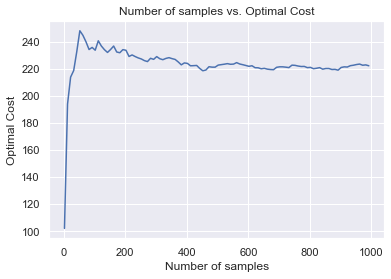

In [7]:
# Plot - optimal cost
plt.plot(samplesizes, optcost)
plt.xlabel("Number of samples")
plt.ylabel("Optimal Cost")
plt.title("Number of samples vs. Optimal Cost")

plt.show()

In [17]:
optcost[22]

230.21261740702707

In [21]:
min(optcost[5:])

218.52624574888264

Similar to the optimal z, the cost starts saturating after n = 220. It lies between 218 and 230 which contains the optimal cost of 221.